# Reddit Flair Detector

---

Note: You can jump straight to the best model - [CNN](#Multichannel-Convolutional-Neural-Network) (93% test-accuracy)

## Part III - Building a Flair Detector

### 1) Import required modules

In [1]:
import nltk
import string
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import warnings
import pickle
from pickle import load
from keras import utils
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Embedding, LSTM, Conv1D, GRU, MaxPooling1D, RNN, Flatten
from keras.layers.merge import concatenate
from keras.callbacks.callbacks import EarlyStopping
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

/home/abhiroop/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/abhiroop/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/abhiroop/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/abhiroop/anaconda3/lib/python3.7/site-packages/tensorflow/python/frame

### 2) Read and load cleaned data CSV

In [2]:
cleaned_data = pd.read_csv("../data/reddit_cleaned_data.csv")
cleaned_data.head()

,flair,title,score,id,author,comms_num,body,url
0,Scheduled,Untouchability even quarantine We never taken ...,52,fzvwz8,sam-sepiol,7,NaN,https://www.telegraphindia.com/india/coronavir...
1,Scheduled,Delhi Govt Sources Names CM Arvind Kejriwal De...,301,f7ogd8,The_andh_bhakth,30,NaN,https://twitter.com/ANI/status/123109390051893...
2,Scheduled,Delhi AP Singh advocate 2012 Delhi gangrape co...,17,flgvah,devCR7,21,NaN,https://twitter.com/ani/status/124073128907587...
3,Scheduled,Why Supreme Court’s verdict SCST quotas create...,110,f1o839,rahulthewall,47,NaN,https://scroll.in/article/952687/why-the-supre...
4,Scheduled,What entrance exams scheduled May,8,fvcvo1,plsacceptmyusername,3,CLAT AILET NEET JEE postponed two weeks Would...,https://www.reddit.com/r/india/comments/fvcvo1...


### 3) Drop unwanted columns and remove ```NaN``` elements from ```body```

* We'll only be using ```title``` and ```body``` columns for classification

In [3]:
flairs = ["Scheduled", "Politics", "Photography", "Coronavirus", "Policy/Economy", "AskIndia", "Sports", "Non-Political",  "Science/Technology", "Food", "Business/Finance"]

cleaned_data.drop(["score","id","author","comms_num","url"], inplace=True, axis=1)
cleaned_data.head()

,flair,title,body
0,Scheduled,Untouchability even quarantine We never taken ...,NaN
1,Scheduled,Delhi Govt Sources Names CM Arvind Kejriwal De...,NaN
2,Scheduled,Delhi AP Singh advocate 2012 Delhi gangrape co...,NaN
3,Scheduled,Why Supreme Court’s verdict SCST quotas create...,NaN
4,Scheduled,What entrance exams scheduled May,CLAT AILET NEET JEE postponed two weeks Would...


In [4]:
cleaned_data['body'] = cleaned_data['body'].astype(str)
invalid_list = ["nan", "[deleted]", "[removed]", "deleted", "removed"]

for x in invalid_list:
    print("Number of", x, "elements:", len(cleaned_data[cleaned_data['body'] == x]))
    
cleaned_data['body'] = cleaned_data['body'].apply(lambda x: '' if x in invalid_list else x)
cleaned_data['body'] = cleaned_data['body'].apply(lambda x: '' if x in invalid_list else x)
print()
for x in invalid_list:
    print("Number of", x, "elements:", len(cleaned_data[cleaned_data['body'] == x]))

Number of nan elements: 1132
Number of [deleted] elements: 0
Number of [removed] elements: 0
Number of deleted elements: 0
Number of removed elements: 0

Number of nan elements: 0
Number of [deleted] elements: 0
Number of [removed] elements: 0
Number of deleted elements: 0
Number of removed elements: 0


### 4) Define a helper function to split the dataset into test and train 

In [5]:
labels = cleaned_data.flair
X_title = cleaned_data.title
X_body = cleaned_data.body

def split_dataset(X,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 21)
    return X_train, X_test, Y_train, Y_test

## Baseline Classification Models

---

### 1) Naive Bayes Classifier for Multinomial Models

* Our first baseline classifier will be a [Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes) classifier. For text, we use the multinomial variant
* Naive Bayes classifiers are a collection of classification algorithms based on Bayes’ Theorem
* Bayes’ Theorem finds the probability of an event occurring given the probability of another event that has already occurred
* It is referred to as a Naive classifier as the features are assumed to independent 
* They are fast and easy to implement but their biggest disadvantage is that the requirement of predictors to be independent. In most of the real life cases, the predictors are dependent, this hinders the performance of the classifier

* We'll try to implement a compound classifier using a ```pipeline```
* A ```pipeline``` is defined by [Scilkit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) as:
> Sequentially apply a list of transforms and a final estimator. Intermediate steps of pipeline must implement fit and transform methods and the final estimator only needs to implement fit.
*  It helps to enforce desired order of application steps which in turn helps in reproducibility and creating a convenient work-flow
* [```CountVectorizer()```](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) converts a collection of text documents to a matrix of token counts
* [```TfidfTransformer()```](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) transforms a count matrix to a normalized tf or tf-idf representation
> Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.
The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [6]:
def nb_model(X_train, X_test, Y_train, Y_test):
    nb = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB()),
                  ])
    nb.fit(X_train, Y_train)
    Y_pred = nb.predict(X_test)
    acc = round(accuracy_score(Y_pred, Y_test)*100,3)
    print("Accuracy:", acc, "%")
    print(classification_report(Y_test, Y_pred, target_names=flairs))

print("Training with Title as a feature:\n")
X_train, X_test, Y_train, Y_test = split_dataset(X_title,labels)
nb_model(X_train, X_test, Y_train, Y_test)

cleaned_data['body'] = cleaned_data['body'].astype(str)
print("Training with Body as a feature:\n")
X_train, X_test, Y_train, Y_test = split_dataset(X_body,labels)
nb_model(X_train, X_test, Y_train, Y_test)

Training with Title as a feature:

Accuracy: 64.706 %
                    precision    recall  f1-score   support

         Scheduled       0.63      0.75      0.69        48
          Politics       0.62      0.40      0.49        57
       Photography       0.59      0.89      0.71        55
       Coronavirus       0.78      0.76      0.77        41
    Policy/Economy       0.76      0.84      0.79        37
          AskIndia       0.71      0.74      0.73        47
            Sports       0.54      0.47      0.50        45
     Non-Political       0.54      0.65      0.59        46
Science/Technology       0.65      0.57      0.61        42
              Food       0.62      0.52      0.57        44
  Business/Finance       0.79      0.56      0.66        48

          accuracy                           0.65       510
         macro avg       0.66      0.65      0.65       510
      weighted avg       0.65      0.65      0.64       510

Training with Body as a feature:

Accuracy:

### 2) Logistic Regression

* Logistic regression is a statistical model that uses a logistic function to model a binary dependent variable
* Mathematically, a binary logistic model has a dependent variable with two possible values, "0" and "1".
* Outputs with more than two values are modeled by multinomial logistic regression 
* The logistic regression model itself simply models probability of output in terms of input and does not perform statistical classification (it is not a classifier), though it can be used to make a classifier, for instance by choosing a cutoff value and classifying inputs with probability greater than the cutoff as one class, below the cutoff as the other; this is a common way to make a binary classifier.


In [7]:
def lr_model(X_train, X_test, Y_train, Y_test):
    lr = Pipeline([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('clf', LogisticRegression(penalty='l2', solver='lbfgs', n_jobs=1, random_state=21, max_iter=100)),
                      ])
    lr.fit(X_train, Y_train)
    Y_pred = lr.predict(X_test)
    acc = round(accuracy_score(Y_pred, Y_test)*100,3)
    print("Accuracy:", acc, "%")
    print(classification_report(Y_test, Y_pred, target_names=flairs))

print("Training with Title as a feature:\n")
X_train, X_test, Y_train, Y_test = split_dataset(X_title,labels)
lr_model(X_train, X_test, Y_train, Y_test)

print("Training with Body as a feature:\n")
X_train, X_test, Y_train, Y_test = split_dataset(X_body,labels)
lr_model(X_train, X_test, Y_train, Y_test)

Training with Title as a feature:

Accuracy: 69.02 %
                    precision    recall  f1-score   support

         Scheduled       0.90      0.79      0.84        48
          Politics       0.48      0.46      0.47        57
       Photography       0.93      0.93      0.93        55
       Coronavirus       0.86      0.73      0.79        41
    Policy/Economy       0.92      0.89      0.90        37
          AskIndia       0.77      0.64      0.70        47
            Sports       0.46      0.51      0.48        45
     Non-Political       0.63      0.72      0.67        46
Science/Technology       0.59      0.64      0.61        42
              Food       0.51      0.64      0.57        44
  Business/Finance       0.72      0.69      0.70        48

          accuracy                           0.69       510
         macro avg       0.71      0.69      0.70       510
      weighted avg       0.70      0.69      0.69       510

Training with Body as a feature:

Accuracy: 

### 3) Linear Support Vector Machine

* This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing learning rate
* This implementation works with data represented as dense or sparse arrays of floating point values for the features. The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM).
* The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1. We use the L2 regularizer for most cases
* The ```log``` loss function results in higher accuracy than ```hinge``` or ```perceptron``` loss

In [8]:
def svm_model(X_train, X_test, Y_train, Y_test):
    svm = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=21, max_iter=10, tol=None))
                   ])
    svm.fit(X_train, Y_train)
    Y_pred = svm.predict(X_test)
    acc = round(accuracy_score(Y_pred, Y_test)*100,3)
    print("Accuracy:", acc, "%")
    print(classification_report(Y_test, Y_pred, target_names=flairs))

print("Training with Title as a feature:\n")
X_train, X_test, Y_train, Y_test = split_dataset(X_title,labels)
svm_model(X_train, X_test, Y_train, Y_test)

print("Training with Body as a feature:\n")
X_train, X_test, Y_train, Y_test = split_dataset(X_body,labels)
svm_model(X_train, X_test, Y_train, Y_test)

Training with Title as a feature:

Accuracy: 68.824 %
                    precision    recall  f1-score   support

         Scheduled       0.84      0.79      0.82        48
          Politics       0.57      0.44      0.50        57
       Photography       0.82      0.93      0.87        55
       Coronavirus       0.84      0.78      0.81        41
    Policy/Economy       0.87      0.89      0.88        37
          AskIndia       0.74      0.62      0.67        47
            Sports       0.49      0.53      0.51        45
     Non-Political       0.57      0.78      0.66        46
Science/Technology       0.62      0.57      0.59        42
              Food       0.55      0.59      0.57        44
  Business/Finance       0.72      0.69      0.70        48

          accuracy                           0.69       510
         macro avg       0.69      0.69      0.69       510
      weighted avg       0.69      0.69      0.69       510

Training with Body as a feature:

Accuracy:

### 4) Random Forest

* Random forest is a model made up of many decision trees
* Rather than just simply averaging the prediction of trees, this model uses two key concepts that gives it the name random:
    * Random sampling of training data points when building trees
    * Random subsets of features considered when splitting nodes

In [9]:
def rf_model(X_train, X_test, Y_train, Y_test):
    rf = Pipeline([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('clf', RandomForestClassifier(n_estimators = 100, random_state = 21))
                      ])
    rf.fit(X_train, Y_train)
    Y_pred = rf.predict(X_test)
    acc = round(accuracy_score(Y_pred, Y_test)*100,3)
    print("Accuracy:", acc, "%")
    print(classification_report(Y_test, Y_pred, target_names=flairs))

print("Training with Title as a feature:\n")
X_train, X_test, Y_train, Y_test = split_dataset(X_title,labels)
rf_model(X_train, X_test, Y_train, Y_test)

print("Training with Body as a feature:\n")
X_train, X_test, Y_train, Y_test = split_dataset(X_body,labels)
rf_model(X_train, X_test, Y_train, Y_test)

Training with Title as a feature:

Accuracy: 67.059 %
                    precision    recall  f1-score   support

         Scheduled       0.89      0.81      0.85        48
          Politics       0.52      0.54      0.53        57
       Photography       0.87      0.87      0.87        55
       Coronavirus       0.83      0.71      0.76        41
    Policy/Economy       0.94      0.84      0.89        37
          AskIndia       0.70      0.66      0.68        47
            Sports       0.38      0.47      0.42        45
     Non-Political       0.78      0.63      0.70        46
Science/Technology       0.57      0.57      0.57        42
              Food       0.45      0.64      0.53        44
  Business/Finance       0.74      0.65      0.69        48

          accuracy                           0.67       510
         macro avg       0.70      0.67      0.68       510
      weighted avg       0.69      0.67      0.68       510

Training with Body as a feature:

Accuracy:

### 5) Multi-Layer Perceptron Classifier

* An MLP Classifier is a modeled Neural Network
* Unlike other classification algorithms such as Support Vectors or Naive Bayes Classifier, MLP Classifier relies on an underlying Neural Network to perform the task of classification

In [10]:
def mlp_model(X_train, X_test, Y_train, Y_test):
    mlp = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MLPClassifier(hidden_layer_sizes=(128,64,32), activation='relu', solver='adam', max_iter=500, random_state=21))
                   ])
    mlp.fit(X_train, Y_train)
    Y_pred = mlp.predict(X_test)
    acc = round(accuracy_score(Y_pred, Y_test)*100,3)
    print("Accuracy:", acc, "%")
    print(classification_report(Y_test, Y_pred, target_names=flairs))

print("Training with Title as a feature:\n")
X_train, X_test, Y_train, Y_test = split_dataset(X_title,labels)
mlp_model(X_train, X_test, Y_train, Y_test)

print("Training with Body as a feature:\n")
X_train, X_test, Y_train, Y_test = split_dataset(X_body,labels)
mlp_model(X_train, X_test, Y_train, Y_test)

Training with Title as a feature:

Accuracy: 54.706 %
                    precision    recall  f1-score   support

         Scheduled       0.67      0.54      0.60        48
          Politics       0.43      0.39      0.41        57
       Photography       0.68      0.58      0.63        55
       Coronavirus       0.70      0.51      0.59        41
    Policy/Economy       0.67      0.59      0.63        37
          AskIndia       0.56      0.62      0.59        47
            Sports       0.38      0.51      0.44        45
     Non-Political       0.42      0.63      0.50        46
Science/Technology       0.57      0.57      0.57        42
              Food       0.52      0.55      0.53        44
  Business/Finance       0.66      0.56      0.61        48

          accuracy                           0.55       510
         macro avg       0.57      0.55      0.55       510
      weighted avg       0.57      0.55      0.55       510

Training with Body as a feature:

Accuracy:

## LSTM - Long Short-Term Memory

---

We humans can remember previous references of words to derive the meaning and context of future words. For example, while reading this sentence, you need to be able to remember at least the last few previous words to make sense of *this* text. Hence, we can safely say that information we acciqure *persists* in the brain.

But in the case of traditional Neural network models, to make information persist is a different ball game. Recurrent neural networks address this issue. They are networks with loops in them, allowing information to persist. A recurrent neural network can be thought of as multiple copies of the same network, each passing a message to a successor.

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" alt="lstm" width="500"/>

Let's implement a regualar LSTM model and try to fit the data:
* First we to encode the labels (flairs) and convert them to categorical values before feeding them to the network
* Then we Tokenize the ```title``` values, generate unique numbers for each word in the corpus and then rebuild the sentences using these values
* To make sure we're feeding sentences with equal length, we also pad our shorter sentences with 0
* We won't use the ```body``` values for prediction as their accuracy is lower than expected
* Split dataset into train and test
* Build a model using a single Embedding and LSTM layer. Feed the LSTM sequences to a dense neural network for classification
* From the accuracy and loss progression plots, we can see that the model is clearly **overfitting**

In [11]:
le = LabelEncoder()
cleaned_data['flair'] = le.fit_transform(cleaned_data['flair'])
cat_values = to_categorical(cleaned_data['flair'], num_classes=11, dtype='int64')

In [12]:
top_words = 8000
max_len = 35

tokenizer = Tokenizer(num_words=top_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(cleaned_data['title'].values)
sequences = tokenizer.texts_to_sequences(cleaned_data['title'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 7263 unique tokens.


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X , cat_values, test_size=0.10, random_state=42)
print((X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

((2295, 35), (2295, 11), (255, 35), (255, 11))


In [14]:
epochs = 50
emb_dim = 128
batch_size = 32

model = Sequential()
model.add(Embedding(top_words,emb_dim, input_length=35))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(11, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 128)           1024000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                1419      
Total params: 1,452,555
Trainable params: 1,452,555
Non-trainable params: 0
____________________________________________

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])


Train on 1836 samples, validate on 459 samples
Epoch 1/50
1836/1836 [==============================] - 9s 5ms/step - loss: 2.3834 - acc: 0.1318 - val_loss: 2.3450 - val_acc: 0.1895
Epoch 2/50
1836/1836 [==============================] - 6s 3ms/step - loss: 2.0201 - acc: 0.3371 - val_loss: 1.8269 - val_acc: 0.3834
Epoch 3/50
1836/1836 [==============================] - 6s 3ms/step - loss: 1.2881 - acc: 0.5861 - val_loss: 1.4415 - val_acc: 0.5708
Epoch 4/50
1836/1836 [==============================] - 6s 3ms/step - loss: 0.7758 - acc: 0.7691 - val_loss: 1.3002 - val_acc: 0.5969
Epoch 5/50
1836/1836 [==============================] - 6s 3ms/step - loss: 0.4730 - acc: 0.8742 - val_loss: 1.3149 - val_acc: 0.6362
Epoch 6/50
1836/1836 [==============================] - 6s 3ms/step - loss: 0.2890 - acc: 0.9292 - val_loss: 1.4242 - val_acc: 0.6340


In [16]:
preds = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(preds[0],preds[1]))

255/255 [==============================] - 0s 866us/step
Test set
  Loss: 1.389
  Accuracy: 0.635


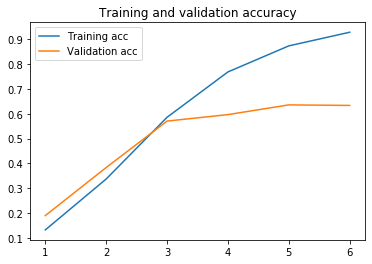

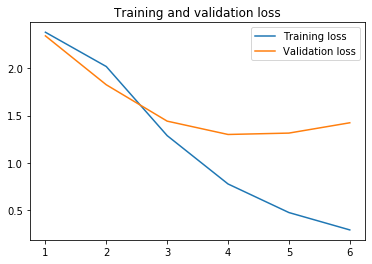

In [17]:
def plot_predictions():
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
plot_predictions()

# Multichannel Convolutional Neural Network

A standard model for document classification is to use an Embedding layer as input, followed by a one-dimensional convolutional neural network, pooling layer, and then a prediction output layer.

The kernel size in the convolutional layer defines the number of words to consider as the convolution is passed across the input text document, providing a grouping parameter.

A multi-channel convolutional neural network for document classification involves using multiple versions of the standard model with different sized kernels. This allows the document to be processed at different resolutions or different n-grams (groups of words) at a time, whilst the model learns how to best integrate these interpretations.

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/10/Depiction-of-the-multiple-channel-convolutional-neural-network-for-text.png" alt="mcnn" width="600"/>

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-018-37387-9/MediaObjects/41598_2018_37387_Fig9_HTML.png?as=webp" alt="flow" width="600"/>

We will define a model with three input channels for processing 4-grams, 6-grams, and 8-grams of text.

Each channel is comprised of the following elements:
* Input layer that defines the length of input sequences.
* Embedding layer set to the size of the vocabulary and 100-dimensional real-valued representations.
* One-dimensional convolutional layer with 32 filters and a kernel size set to the number of words to read at once.
* Max Pooling layer to consolidate the output from the convolutional layer.
* Flatten layer to reduce the three-dimensional output to two dimensional for concatenation.

The output from the three channels are concatenated into a single vector and process by a Dense layer and an output layer.


In [18]:
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 128)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 128)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 128)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(11, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    print(model.summary())
    return model

model = define_model(max_len, top_words)

history = model.fit([X_train,X_train,X_train], np.array(Y_train), epochs=10, batch_size=16, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=2, min_delta=0.0001)])



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 128)      1024000     input_1[0][0]                    
___________________________________________________________________________________________

In [19]:
preds = model.evaluate([X_test,X_test,X_test], np.array(Y_test))
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(preds[0],preds[1]))

255/255 [==============================] - 0s 278us/step
Test set
  Loss: 0.227
  Accuracy: 0.927


In [21]:
# save the model and tokenizer to disk
model.save("../models/model.h5")

with open('../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)